# Clustering & outlier detection code for 9-12% Cr data

This code will explore clustering techniques and outlier detection for the 9-12% Cr data.

In [1]:
# import libraries
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Import data
df_tensile_numeric = pd.read_csv('9_12Cr_all_data_cleaned.csv')

In [3]:
# Run this to see all rows, columns of output
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [4]:
# Get copy of data without labels
df_tensile_numeric_nolabel = df_tensile_numeric.iloc[:, :-2]

### Get unique composition, heat treatment, homogenization, microstructure grain size

In [5]:
# Set attributes included and order
df_tensile_outliers_ID = df_tensile_numeric.loc[:, ['Fe', 'C', 'Cr', 'Mn', 'Si', 'Ni', 'Co', 'Mo', 'W', 'Nb', 'Al', 'P', 'Cu', 'Ta', 'V', 'B', 'N', 'O', 'S', 'Homo', 'Normal', 'Temper1', 'AGS No.', 'Alloy_ID_Unique', 'Alloy_ID_fixed']]

In [6]:
# Get unique values only

df_tensile_outliers_ID = df_tensile_outliers_ID.drop_duplicates(keep='first')
df_tensile_outliers_ID = df_tensile_outliers_ID.reset_index(drop=True)

df_tensile_outliers = df_tensile_outliers_ID.iloc[:, 0:23]
df_tensile_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 23 columns):
Fe         288 non-null float64
C          288 non-null float64
Cr         288 non-null float64
Mn         288 non-null float64
Si         288 non-null float64
Ni         288 non-null float64
Co         199 non-null float64
Mo         288 non-null float64
W          211 non-null float64
Nb         226 non-null float64
Al         255 non-null float64
P          288 non-null float64
Cu         224 non-null float64
Ta         180 non-null float64
V          237 non-null float64
B          204 non-null float64
N          255 non-null float64
O          184 non-null float64
S          288 non-null float64
Homo       145 non-null float64
Normal     285 non-null float64
Temper1    276 non-null float64
AGS No.    124 non-null float64
dtypes: float64(23)
memory usage: 51.9 KB


In [7]:
# Save a copy of the dataframe with missing values
df_tensile_numeric_mv = df_tensile_outliers.copy(deep=True)
df_tensile_outliers_ID_mv = df_tensile_outliers_ID.copy(deep=True)

## Examine distributions of attributes, with missing values

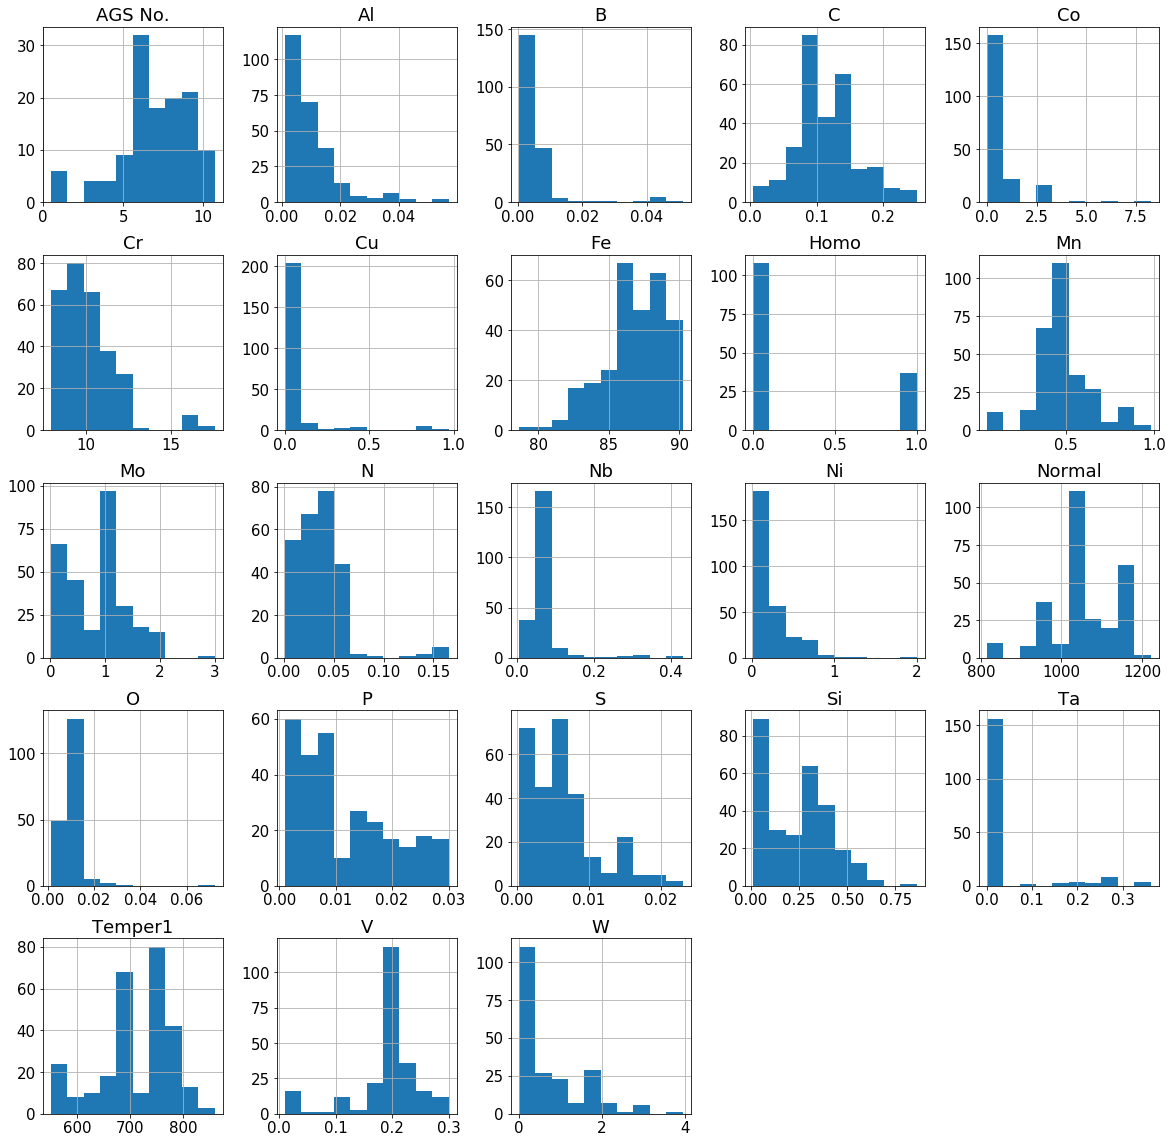

In [8]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
df_tensile_numeric_mv.hist(figsize = (20,20));

In [9]:
# range of data before missing values filled
df_tensile_outliers.describe()

,Fe,C,Cr,Mn,Si,Ni,Co,Mo,W,Nb,Al,P,Cu,Ta,V,B,N,O,S,Homo,Normal,Temper1,AGS No.
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,199.000000,288.000000,211.000000,226.000000,255.000000,288.000000,224.000000,180.000000,237.000000,204.000000,255.000000,184.000000,288.000000,145.000000,285.000000,276.000000,124.000000
mean,86.829368,0.115752,10.074951,0.483538,0.239458,0.239535,0.501992,0.829201,0.659098,0.068033,0.010058,0.011318,0.071405,0.032652,0.191657,0.004595,0.037873,0.009826,0.006300,0.255172,1052.768421,714.322464,6.962097
std,2.139948,0.046898,1.679977,0.158860,0.165761,0.236911,1.129659,0.558511,0.844949,0.056003,0.009015,0.008586,0.144251,0.085899,0.061034,0.008221,0.026595,0.006295,0.004646,0.437469,79.286313,69.275269,2.222596
min,78.611000,0.004000,7.915000,0.050000,0.010000,0.010000,0.008000,0.010000,0.005000,0.005000,0.001000,0.001000,0.002000,0.000300,0.010000,0.000300,0.001000,0.001400,0.000300,0.000000,815.000000,550.000000,0.500000
25%,85.690100,0.085375,8.920000,0.410000,0.078000,0.080000,0.015000,0.412500,0.010000,0.050000,0.005000,0.005000,0.020000,0.000300,0.190000,0.000300,0.019000,0.008000,0.002850,0.000000,1030.000000,700.000000,6.000000
50%,86.903450,0.110000,9.730000,0.460000,0.257000,0.160000,0.015000,0.950000,0.050000,0.058500,0.008000,0.008000,0.050000,0.000300,0.200000,0.001000,0.035000,0.010000,0.005000,0.000000,1050.000000,740.000000,7.000000
75%,88.573100,0.150000,10.977500,0.560000,0.360000,0.310000,0.050000,1.086250,1.095000,0.073750,0.013000,0.017000,0.050000,0.000300,0.220000,0.008350,0.050000,0.010000,0.008500,1.000000,1100.000000,760.000000,8.650000
max,90.222600,0.250000,17.550000,0.980000,0.860000,2.000000,8.226000,2.990000,3.930000,0.430000,0.057000,0.030000,0.970000,0.361000,0.300000,0.051000,0.165100,0.072000,0.023000,1.000000,1221.000000,860.000000,10.700000


# Fill in missing values

In [10]:
# fill in Homogenization column (0/1) with 0
df_tensile_outliers_ID['Homo'].fillna(value = 0, inplace = True)
df_tensile_outliers['Homo'].fillna(value = 0, inplace = True)

In [11]:
# fill rest of blanks/NaNs with mean of column
df_tensile_outliers_ID.fillna(value = df_tensile_outliers_ID.mean(), inplace = True)
df_tensile_outliers.fillna(value = df_tensile_outliers.mean(), inplace = True)

In [12]:
# range of data with missing values filled in
df_tensile_outliers_ID.describe()

,Fe,C,Cr,Mn,Si,Ni,Co,Mo,W,Nb,Al,P,Cu,Ta,V,B,N,O,S,Homo,Normal,Temper1,AGS No.
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,86.829368,0.115752,10.074951,0.483538,0.239458,0.239535,0.501992,0.829201,0.659098,0.068033,0.010058,0.011318,0.071405,0.032652,0.191657,0.004595,0.037873,0.009826,0.006300,0.128472,1052.768421,714.322464,6.962097
std,2.139948,0.046898,1.679977,0.158860,0.165761,0.236911,0.938294,0.558511,0.722769,0.049586,0.008481,0.008586,0.127154,0.067838,0.055346,0.006914,0.025019,0.005026,0.004646,0.335197,78.870836,67.811542,1.455031
min,78.611000,0.004000,7.915000,0.050000,0.010000,0.010000,0.008000,0.010000,0.005000,0.005000,0.001000,0.001000,0.002000,0.000300,0.010000,0.000300,0.001000,0.001400,0.000300,0.000000,815.000000,550.000000,0.500000
25%,85.690100,0.085375,8.920000,0.410000,0.078000,0.080000,0.015000,0.412500,0.010000,0.054000,0.005000,0.005000,0.029250,0.000300,0.190000,0.000300,0.020525,0.009826,0.002850,0.000000,1036.000000,700.000000,6.962097
50%,86.903450,0.110000,9.730000,0.460000,0.257000,0.160000,0.040000,0.950000,0.659098,0.065000,0.009000,0.008000,0.050000,0.001000,0.200000,0.004298,0.037873,0.009826,0.005000,0.000000,1050.000000,720.000000,6.962097
75%,88.573100,0.150000,10.977500,0.560000,0.360000,0.310000,0.501992,1.086250,0.850000,0.070000,0.011850,0.017000,0.071405,0.032652,0.210000,0.004595,0.050000,0.010000,0.008500,0.000000,1100.000000,760.000000,6.962097
max,90.222600,0.250000,17.550000,0.980000,0.860000,2.000000,8.226000,2.990000,3.930000,0.430000,0.057000,0.030000,0.970000,0.361000,0.300000,0.051000,0.165100,0.072000,0.023000,1.000000,1221.000000,860.000000,10.700000


## Scale data, apply PCA and kMeans

In [13]:
# Scale data
df_scale = StandardScaler().fit_transform(df_tensile_outliers)

In [14]:
# Apply PCA

# Make an instance of the Model
pca_model = PCA(n_components = 0.90)

# fit PCA on training set
data_PCA = pca_model.fit_transform(df_scale)
df_PCA = pd.DataFrame(data = data_PCA)

pca_model.explained_variance_ratio_

array([0.17273758, 0.1600583 , 0.10375334, 0.07622217, 0.06311662,
       0.05684611, 0.05218434, 0.04703167, 0.03883836, 0.03598207,
       0.0334316 , 0.02685245, 0.02479354, 0.02264844])

In [15]:
pca_model.n_components_

14

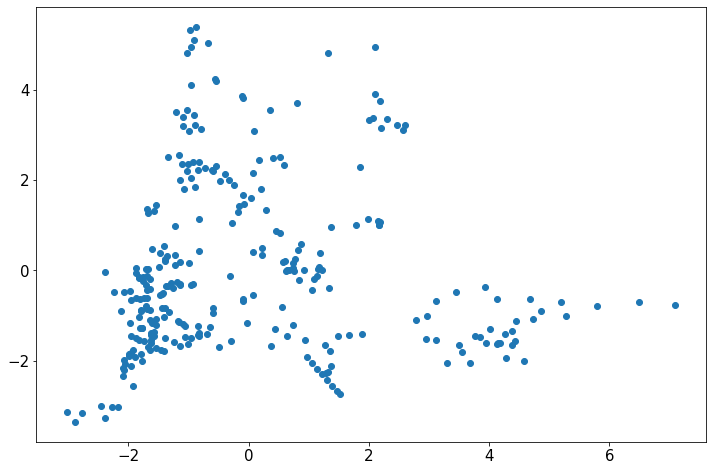

In [16]:
plt.figure(figsize = (12,8))
plt.scatter(df_PCA[0], df_PCA[1]);

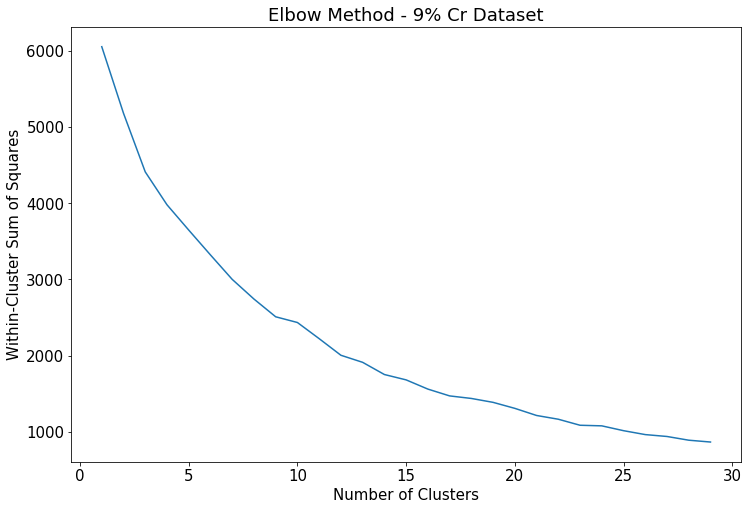

In [17]:
# Elbow method to determine optimum number of clusters
plt.figure(figsize = (12,8))

wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_PCA) # X_PCA
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 30), wcss)
plt.title('Elbow Method - 9% Cr Dataset')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.savefig('PCA_kMeans_elbow_9Cr.png')
plt.show();

In [18]:
# Set number of clusters using domain knowledge
num_clusters = 14

In [19]:
# Run k-Means clustering
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1000, n_init=100, random_state=0)
pred_y = kmeans.fit_predict(df_PCA)

In [20]:
# Add kMeans labels to dataset
df_tensile_outliers_ID['kMeans_label'] = kmeans.labels_

following code adjusted from:
https://stackoverflow.com/questions/54240144/distance-between-nodes-and-the-centroid-in-a-kmeans-cluster

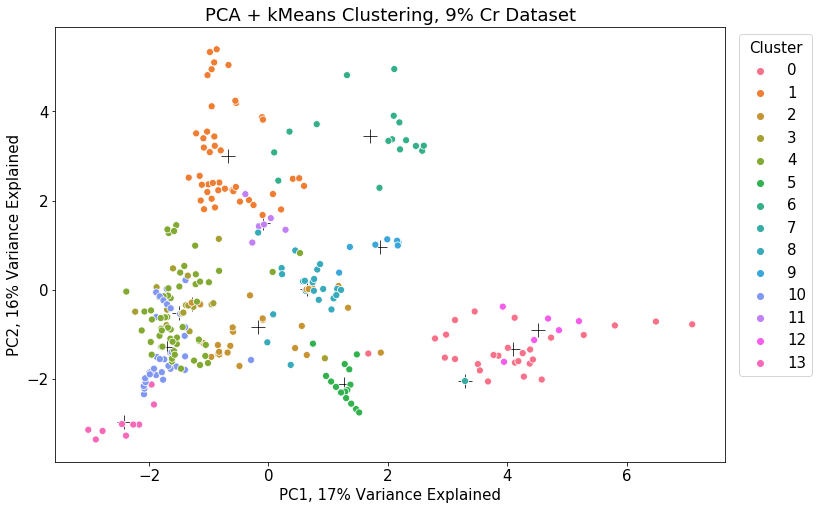

In [21]:
# plot
plt.figure(figsize = (12,8))
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
                marker='+', 
                color='black', 
                s=200);
sns.scatterplot(df_PCA[0], df_PCA[1], hue=pred_y, 
                palette=sns.color_palette("husl", n_colors=num_clusters), s = 50)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, title = "Cluster")
plt.title('PCA + kMeans Clustering, 9% Cr Dataset')
# Set x-axis label
plt.xlabel('PC1, %d' %(pca_model.explained_variance_ratio_[0]*100).round(0) + '% Variance Explained')
# Set y-axis label
plt.ylabel('PC2, %d' %(pca_model.explained_variance_ratio_[1]*100).round(0) + '% Variance Explained')
plt.show();

### Summarize k-Means cluster attributes

In [22]:
# filter out clusters with 2 or less points (get average values)
df_tensile_outliers_ID_kMgr1 = df_tensile_outliers_ID.groupby('kMeans_label').filter(lambda x : len(x)>2)

In [23]:
df_tensile_outliers_ID_kMgr1.groupby(df_tensile_outliers_ID_kMgr1.kMeans_label).mean()

,Fe,C,Cr,Mn,Si,Ni,Co,Mo,W,Nb,Al,P,Cu,Ta,V,B,N,O,S,Homo,Normal,Temper1,AGS No.
kMeans_label,,,,,,,,,,,,,,,,,,,,,,,
0,84.986464,0.151857,10.029607,0.440857,0.132893,0.213857,2.143571,0.927071,0.477704,0.059261,0.012221,0.001357,0.037665,0.188764,0.205464,0.009686,0.022314,0.004396,0.005621,1.000000,1150.000000,700.000000,6.318721
1,85.569334,0.125682,12.854091,0.591818,0.356136,0.245909,0.446652,0.168409,0.585337,0.060870,0.010995,0.024909,0.070308,0.028976,0.201696,0.004107,0.034383,0.009846,0.009750,0.000000,940.340909,719.520504,8.000238
2,86.406892,0.094008,9.489231,0.455385,0.138077,0.176538,0.604614,0.399231,1.895385,0.050346,0.008346,0.006154,0.048693,0.014849,0.179615,0.002892,0.043527,0.008893,0.003054,0.076923,1069.230769,766.846154,7.189144
3,87.229850,0.060156,9.530437,0.567312,0.380688,0.175000,0.045687,1.784375,0.111819,0.035631,0.005750,0.007313,0.042688,0.002366,0.054169,0.001325,0.016381,0.009752,0.008500,0.062500,1037.562500,720.937500,7.141835
4,88.830237,0.100214,8.793393,0.436250,0.385714,0.125821,0.210497,0.930304,0.270360,0.087042,0.009929,0.013563,0.068336,0.014743,0.207290,0.002342,0.041646,0.009672,0.004395,0.000000,1031.523308,755.052989,7.550446
5,88.207307,0.162000,9.256667,0.106667,0.093333,0.088667,0.574594,1.553333,0.572218,0.055400,0.011333,0.005800,0.066551,0.030495,0.254000,0.008233,0.016667,0.009323,0.001620,0.000000,1122.933333,579.333333,6.962097
6,83.902794,0.180875,11.721250,0.680625,0.380625,0.776875,0.107749,1.211250,0.737444,0.052275,0.031941,0.019375,0.078875,0.024564,0.245729,0.003521,0.023011,0.010682,0.010125,0.000000,1024.375000,655.000000,5.009274
8,85.900177,0.133000,10.461364,0.490909,0.062727,0.620909,0.148317,0.723182,1.244050,0.059909,0.004912,0.007227,0.055838,0.009123,0.177727,0.001594,0.047776,0.009570,0.004473,0.000000,1071.136364,597.727273,6.872911
9,86.285400,0.205000,10.440000,0.867500,0.351250,0.053750,0.015000,1.396250,0.010000,0.120000,0.005000,0.007375,0.015000,0.000300,0.153750,0.039250,0.012750,0.010000,0.012125,0.000000,1150.000000,650.000000,6.962097


## Calculate z-value

In [24]:
# Calculate distance of each point from cluster center

dist_cluster = kmeans.transform(df_PCA)
dist_cluster_sq = kmeans.transform(df_PCA)**2

In [25]:
df_dist_cluster = pd.DataFrame(dist_cluster_sq.sum(axis=1).round(2), columns=['sqdist'])
df_dist_cluster['label'] = pd.DataFrame(pred_y)

In [26]:
df_dist_cluster

,sqdist,label
0,908.50,13
1,1354.50,13
2,1186.20,13
3,1391.24,13
4,630.83,2
5,788.00,13
6,833.68,13
7,1027.56,13
8,1322.35,13
9,1166.52,13


In [27]:
# for each cluster, find the z values (# of st. dev away from cluster center)

# create a copy of the dataframe
df_dist_cluster2 = df_dist_cluster.copy(deep=True)
# create a blank list for collecting dataframe subsets
df_zvalue = []

for label in np.unique(kmeans.labels_):
    # subset dataframe by label
    label_subset = df_dist_cluster2[df_dist_cluster2['label'] == label]
    # calculate zscore for each point
    label_subset['zval_stats'] = stats.zscore(label_subset['sqdist'])
    df_zvalue.append(label_subset)

# Concatenate list of dataframes into one dataframe
df_zvalue_whole = pd.concat(df_zvalue)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [28]:
#df_zvalue_whole.sort_index(inplace=True)

## Set z-score threshold

In [29]:
# find points that are more than one standard deviation away from the mean
outlier_indices = df_zvalue_whole.index[df_zvalue_whole['zval_stats'] >= 1]

In [30]:
outlier_indices

Int64Index([156, 157, 167, 247, 248, 249, 250, 251, 252, 253, 254, 255,  12,
             13,  15,  29, 194, 231, 232,  38,  23,  94,  55,  56,  57,  59,
             60,  61, 202, 237,   1,   3],
           dtype='int64')

In [31]:
# Indicate outliers in the dataset
df_tensile_outliers_ID['outlier_identified_zvalue'] = 0
df_tensile_outliers_ID.loc[outlier_indices, 'outlier_identified_zvalue'] = 1

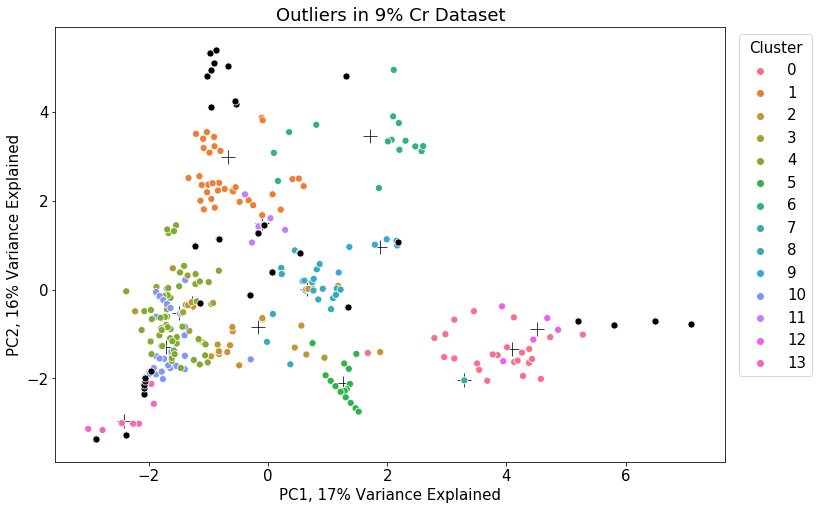

In [32]:
# replot, but highlight the outliers as given by z-value
plt.figure(figsize = (12,8))

sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
                marker='+', 
                color='black', 
                s=200);
sns.scatterplot(df_PCA[0], df_PCA[1], hue=pred_y, 
                palette=sns.color_palette("husl", n_colors=num_clusters), s = 50);
# highlight the furthest point in black
sns.scatterplot(df_PCA.iloc[outlier_indices, 0], df_PCA.iloc[outlier_indices, 1], color='black', s = 50)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, title = "Cluster")
plt.title('Outliers in 9% Cr Dataset')
# Set x-axis label
plt.xlabel('PC1, %d' %(pca_model.explained_variance_ratio_[0]*100).round(0) + '% Variance Explained')
# Set y-axis label
plt.ylabel('PC2, %d' %(pca_model.explained_variance_ratio_[1]*100).round(0) + '% Variance Explained')
plt.show();

### Find points belonging to clusters with 1 or 2 points

In [33]:
Kmeans_smcl_all = df_tensile_outliers_ID['kMeans_label'].value_counts().reset_index(name = "count")
Kmeans_smcl_all

,index,count
0,4,56
1,1,44
2,10,35
3,0,28
4,2,26
5,8,22
6,6,16
7,3,16
8,5,15
9,13,9


In [34]:
# Find kMeans clusters where only  1 or 2 data points per cluster

Kmeans_smcl = df_tensile_outliers_ID['kMeans_label'].value_counts().reset_index(name = "count").query("count <= 2")["index"]
Kmeans_smcl

13    7
Name: index, dtype: int64

In [35]:
# make a list of kMeans clusters with low data points
Kmeans_smcl = Kmeans_smcl.tolist()

In [36]:
# find rows of df_tensile_outliers_ID where kMeans_label is in the list above: Kmeans_smcl
outlier_indices_cl = df_tensile_outliers_ID.index[df_tensile_outliers_ID['kMeans_label'].isin(Kmeans_smcl)]

In [37]:
# Indicate outliers in the dataset
df_tensile_outliers_ID['outlier_identified_zvalue_cl'] = 0
df_tensile_outliers_ID.loc[outlier_indices, 'outlier_identified_zvalue_cl'] = 1
df_tensile_outliers_ID.loc[outlier_indices_cl, 'outlier_identified_zvalue_cl'] = 1

In [38]:
Kmeans_all = df_tensile_outliers_ID[df_tensile_outliers_ID['outlier_identified_zvalue_cl'] == 1]['kMeans_label'].value_counts()
Kmeans_all

1     9
10    6
4     3
2     3
0     3
13    2
12    1
11    1
9     1
8     1
7     1
6     1
3     1
Name: kMeans_label, dtype: int64

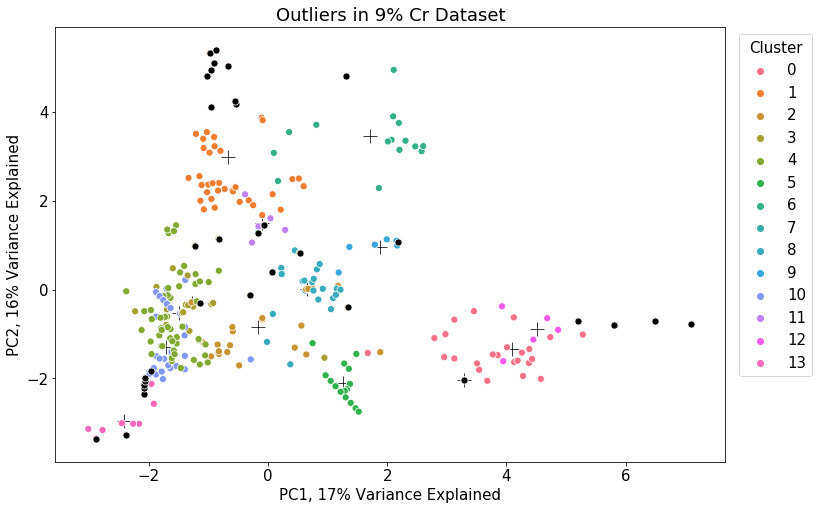

In [39]:
# replot, but highlight the outliers as given by z-value AND small cluster values
plt.figure(figsize = (12,8))

sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='+', color='black', s=200);
sns.scatterplot(df_PCA[0], df_PCA[1], hue=pred_y, 
                palette=sns.color_palette("husl", n_colors=num_clusters), s = 50);
# highlight the furthest point in black
sns.scatterplot(df_PCA.iloc[outlier_indices, 0], df_PCA.iloc[outlier_indices, 1], color='black', s = 50)
# highlight the furthest point in black
sns.scatterplot(df_PCA.iloc[outlier_indices_cl, 0], df_PCA.iloc[outlier_indices_cl, 1], color='black', s = 50)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, title = "Cluster")
plt.title('Outliers in 9% Cr Dataset')
# Set x-axis label
plt.xlabel('PC1, %d' %(pca_model.explained_variance_ratio_[0]*100).round(0) + '% Variance Explained')
# Set y-axis label
plt.ylabel('PC2, %d' %(pca_model.explained_variance_ratio_[1]*100).round(0) + '% Variance Explained')
plt.show();

## Plot outliers vs. original attributes

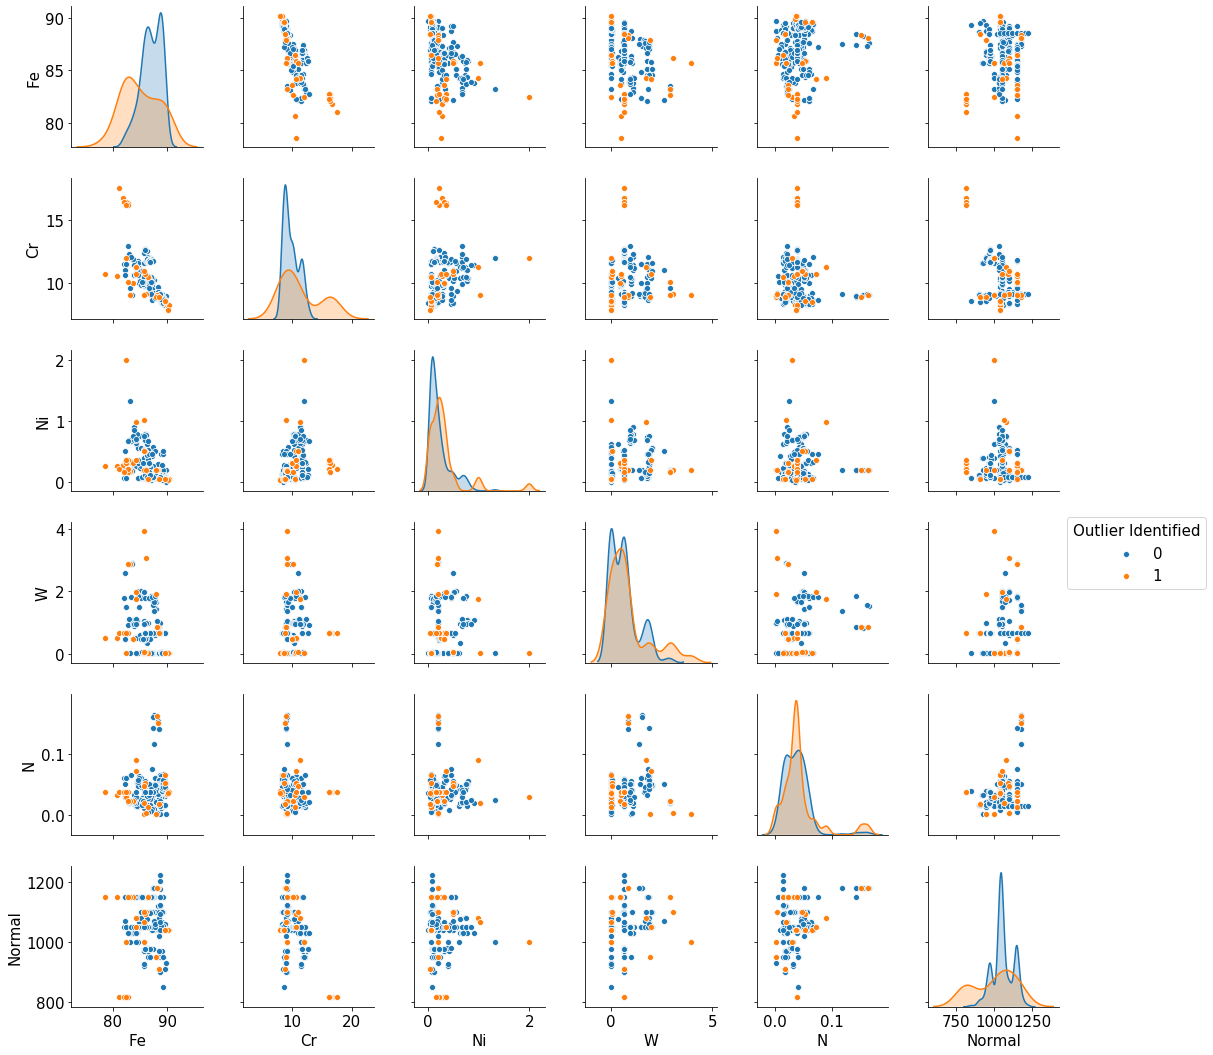

In [40]:
g = sns.pairplot(df_tensile_outliers_ID, vars = df_tensile_outliers_ID[['Fe', 'Cr', 'Ni', 'W', 'N', 'Normal']], hue = "outlier_identified_zvalue_cl")
g._legend.remove()
plt.legend(bbox_to_anchor=(1, 2), loc='center left', ncol=1, title = 'Outlier Identified')
plt.show();

## Run Regression to compare with outliers and without

In [41]:
# identify which data points are outliers, combine this with original full dataset

df_tensile_outliers_only =  df_tensile_outliers_ID.iloc[: , 24:29]

# Drop duplicates... so merge is 1:many rather than many:many
df_tensile_outliers_only.drop_duplicates(keep='first', inplace = True)

df_tensile_outliers_only

,Alloy_ID_fixed,kMeans_label,outlier_identified_zvalue,outlier_identified_zvalue_cl
0,MAP_039,13,0,0
1,MAP_040,13,1,1
2,MAP_041,13,0,0
3,MAP_042,13,1,1
4,MAP_043,2,0,0
5,MAP_044,13,0,0
6,MAP_045,13,0,0
7,MAP_046,13,0,0
8,MAP_047,13,0,0
9,MAP_048,13,0,0


In [42]:
df_tensile_outliers_only.shape[0]

284

In [43]:
# append outlier info to 9Cr alloys and test data
df_tensile_alldata_outliers_identified = pd.merge(df_tensile_numeric, df_tensile_outliers_only, on='Alloy_ID_fixed', how='left')

In [44]:
df_tensile_alldata_outliers_identified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5485 entries, 0 to 5484
Data columns (total 83 columns):
CT_RT                           3054 non-null float64
CT_CS                           3320 non-null float64
CT_Temp                         3320 non-null float64
Fe                              5485 non-null float64
C                               5485 non-null float64
Si                              5485 non-null float64
Mn                              5485 non-null float64
P                               5485 non-null float64
S                               5485 non-null float64
Cr                              5485 non-null float64
Mo                              5485 non-null float64
W                               3973 non-null float64
Ni                              5485 non-null float64
Cu                              4269 non-null float64
V                               4755 non-null float64
Nb                              3464 non-null float64
N                            

In [45]:
# Need to fill in missing values
# Reduce dataset to variables considered

# drop rows that have CT_RT blank... this is the target variable
df_tensile_alldata_outliers_identified = df_tensile_alldata_outliers_identified.dropna(subset = ['CT_RT'])

# Drop attributes that are all blank
df_tensile_alldata_outliers_identified = df_tensile_alldata_outliers_identified.dropna(axis=1, how='all')

In [46]:
# Version with no outliers 
df_tensile_alldata_no_outliers = df_tensile_alldata_outliers_identified[df_tensile_alldata_outliers_identified['outlier_identified_zvalue_cl'] != 1]

In [47]:
# total number of points with test data
df_tensile_alldata_outliers_identified.shape[0]

3054

In [48]:
# number of outlier points removed from dataset
num_outliers = df_tensile_alldata_outliers_identified.shape[0] - df_tensile_alldata_no_outliers.shape[0]
num_outliers

193

In [49]:
# switch here for outliers/ no outliers
df_tensile_alldata_outliers_reduced = df_tensile_alldata_outliers_identified.drop(['Ms_time', 'Label_verma', 
                                                                                   'kMeans_label', 'outlier_identified_zvalue',
                                                                                   'outlier_identified_zvalue_cl',
                                                                                   'Alloy_ID_Unique', 'Alloy_ID_fixed', 'Source ID',
                                                                                   'Temper2', 'Ingot Size (kg)', 'OD or T (mm)',
                                                                                   'WT or W (mm)', 'L (mm)', 'Ni_eq',
                                                                                   'Cr_eq', 'Mo_eq'], 
                                                                                  axis = 1)

# this version for kMeans cluster labels
df_tensile_alldata_outliers_wclusters = df_tensile_alldata_outliers_identified.drop(['Ms_time', 'Label_verma', 
                                                                                   'outlier_identified_zvalue',
                                                                                   'outlier_identified_zvalue_cl',
                                                                                   'Alloy_ID_Unique', 'Alloy_ID_fixed', 'Source ID',
                                                                                   'Temper2', 'Ingot Size (kg)', 'OD or T (mm)',
                                                                                   'WT or W (mm)', 'L (mm)', 'Ni_eq',
                                                                                   'Cr_eq', 'Mo_eq'], 
                                                                                  axis = 1)

In [50]:
# Fill data with mean of column
df_tensile_alldata_outliers_reduced['Homo'].fillna(value = 0, inplace = True)
df_tensile_alldata_outliers_reduced.fillna(value = df_tensile_alldata_outliers_reduced.mean(), inplace = True)

In [51]:
df_tensile_alldata_outliers_wclusters['kMeans_label'].value_counts()

4     915
2     391
6     388
1     253
8     251
11    224
10    174
3     172
5     115
13     66
0      52
12     28
9      24
7       1
Name: kMeans_label, dtype: int64

In [52]:
df_tensile_alldata_outliers_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 0 to 5418
Data columns (total 38 columns):
CT_RT          3054 non-null float64
CT_CS          3054 non-null float64
CT_Temp        3054 non-null float64
Fe             3054 non-null float64
C              3054 non-null float64
Si             3054 non-null float64
Mn             3054 non-null float64
P              3054 non-null float64
S              3054 non-null float64
Cr             3054 non-null float64
Mo             3054 non-null float64
W              3054 non-null float64
Ni             3054 non-null float64
Cu             3054 non-null float64
V              3054 non-null float64
Nb             3054 non-null float64
N              3054 non-null float64
Al             3054 non-null float64
B              3054 non-null float64
Co             3054 non-null float64
Ta             3054 non-null float64
O              3054 non-null float64
Normal         3054 non-null float64
Temper1        3054 non-null float64
Homo 

Mean Absolute Error: 5263.41 MPa.
Results on training data
MSE: 63710822.883218266
RMSE: 7981.905968076689
R-squared:  0.8798
Pearsons Correlation Coefficient:  (0.9432982208302811, 0.0)
------------------------
Results on testing data
MSE: 130662989.2802965
RMSE: 11430.791279710102
R-squared:  0.7089
Pearsons Correlation Coefficient:  (0.8423573813181916, 6.912909517965433e-248)
------------------------
Mean Absolute Percentage Error
Accuracy: -1379.82 %.
Feature ranking:
1. CT_MCR (0.228761)
2. CT_2.0% CS (0.190620)
3. CT_Temp (0.143830)
4. CT_CS (0.128576)
5. CT_RA (0.098461)
6. CT_TTC (0.038323)
7. CT_EL (0.035471)
8. Si (0.032540)
9. Cu (0.014883)
10. Normal (0.012285)
11. Ta (0.011298)
12. Nb (0.011248)
13. AGS No. (0.007652)
14. Fe (0.006680)
15. CT_5.0% CS (0.005927)
16. CT_1.0% CS (0.005804)
17. V (0.005207)
18. Cr (0.004397)
19. Mn (0.003086)
20. Mo (0.002942)
21. N (0.002709)
22. Temper1 (0.002571)
23. Al (0.002425)
24. C (0.001558)
25. S (0.001111)
26. CT_0.5% CS (0.000775)

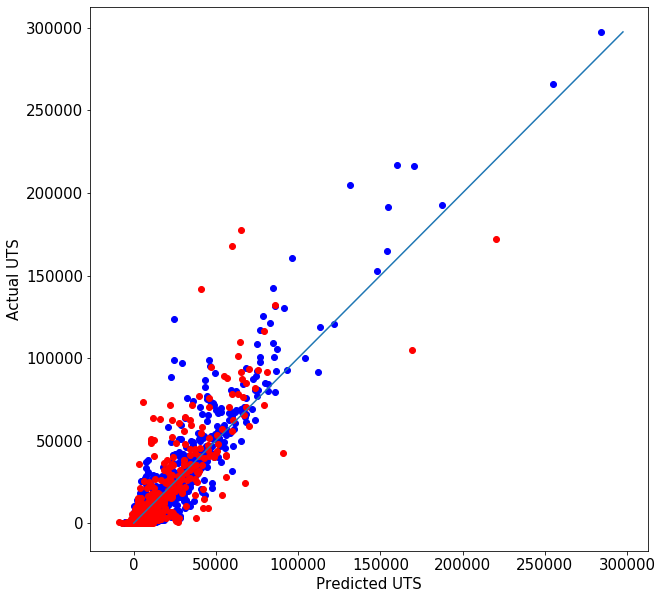

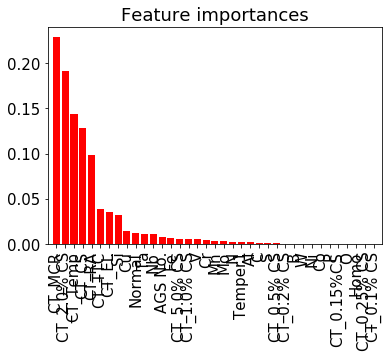

In [53]:
# Set y as target variable: CT_RT
# X as rest of dataset, independent variables

y = df_tensile_alldata_outliers_reduced['CT_RT']
X = df_tensile_alldata_outliers_reduced.drop(['CT_RT'], axis = 1)

X = X.astype('float64')
y = y.astype('float64')

# Scale dataset using MinMaxScaler from scikit learn
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_array = y.to_numpy()

# Using Skicit-learn to split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y_array, test_size=0.3, random_state = 1)

# Grid search for optimizing hyperparameters
# baseline: n_estimators:100; max_depth = 50; warm_start = True
#params = {'n_estimators':809, 'max_depth':53, 'random_state': 1, 'warm_start':False}
params = {'n_estimators':100, 'max_depth':50, 'random_state': 1, 'warm_start':True}
# Run random forest regression
#model = RandomForestRegressor(**params)

model = GradientBoostingRegressor(random_state = 1)
model.fit(X_train, Y_train)

# Calculate the mean squared error (MSE) and R-squared of the test set predictions.
plt.figure(figsize=(10, 10))
plt.scatter(model.predict(X_train),Y_train, color='blue')
plt.scatter(model.predict(X_test),Y_test, color='red')
#plt.title("Feature importances: %s" % (cluster))
plt.xlabel('Predicted UTS')
plt.ylabel('Actual UTS')

# plot diagonal line
plt.plot([y_array.min(), y_array.max()], [[y_array.min()], [y_array.max()]])

# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'MPa.')


print('Results on training data')
print("MSE:", mean_squared_error(Y_train, model.predict(X_train)))
print('RMSE:',np.sqrt(mean_squared_error(Y_train, model.predict(X_train))))
print('R-squared: ', round(r2_score(Y_train, model.predict(X_train)), 4))
print('Pearsons Correlation Coefficient: ', pearsonr(Y_train, model.predict(X_train)))
print('------------------------')
print('Results on testing data')
print("MSE:", mean_squared_error(Y_test, model.predict(X_test)))
print('RMSE:',np.sqrt(mean_squared_error(Y_test, model.predict(X_test))))
print('R-squared: ', round(r2_score(Y_test, model.predict(X_test)), 4))
print('Pearsons Correlation Coefficient: ', pearsonr(Y_test, model.predict(X_test)))
print('------------------------')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Mean Absolute Percentage Error')
print('Accuracy:', round(accuracy, 2), '%.')

# Calculate feature importances
col_names = list(df_tensile_alldata_outliers_reduced.drop(['CT_RT'], axis = 1).columns.values)
col_name_array = np.asarray(col_names)
featimp = model.feature_importances_
# Create a 2D array with importances and features
feature_imp = np.vstack((col_name_array, model.feature_importances_))

# Plot feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(col_name_array, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

indices = np.argsort(featimp)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_imp[0, indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), np.array(importances)[indices.astype(int)],
        color="r", align="center") # , yerr=std[indices]
plt.xticks(range(X.shape[1]), feature_imp[0, indices], rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.show()